In [2]:
%pip install dynamiqs

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\squan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import numpy as np

import dynamiqs as dq
import jax.numpy as jnp       
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from functools import reduce     # Import reduce to sum qarrays without starting with 0

In [12]:
# Hilbert-space truncations
na = 20   # Buffer mode a 
nb = 5    # Memory mode b

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Mode a annihilation operator
adag = a.dag()                                # Mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Mode b annihilation operator
bdag = b.dag()                                # Mode b creation operator

# Other parameters
g_2 = 1.0
eps_d = -4.0
kappa_b = 10

# Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag
H = H_2ph + H_d


a = dq.destroy(na) # annihilaiton operator

psi0 = dq.fock(na, 0) # initial state

# H = dq.zeros(na) # zero Hamiltonian
kappa_2 = 1 # two-photon loss rate
alpha = 2.0 # cat size
tsave = np.linspace(0, 3, 100)
loss_op = np.sqrt(kappa_2)*(a @ a - alpha**2 * dq.eye(na)) # loss operator
res = dq.mesolve(H, [loss_op], psi0, tsave)
dq.plot.wigner_gif(res.states)

ValueError: Terms are not compatible with solver!

|██████████| 100.0% ◆ elapsed 243.05ms ◆ remaining 0.00ms  


c:\Users\squan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\squan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


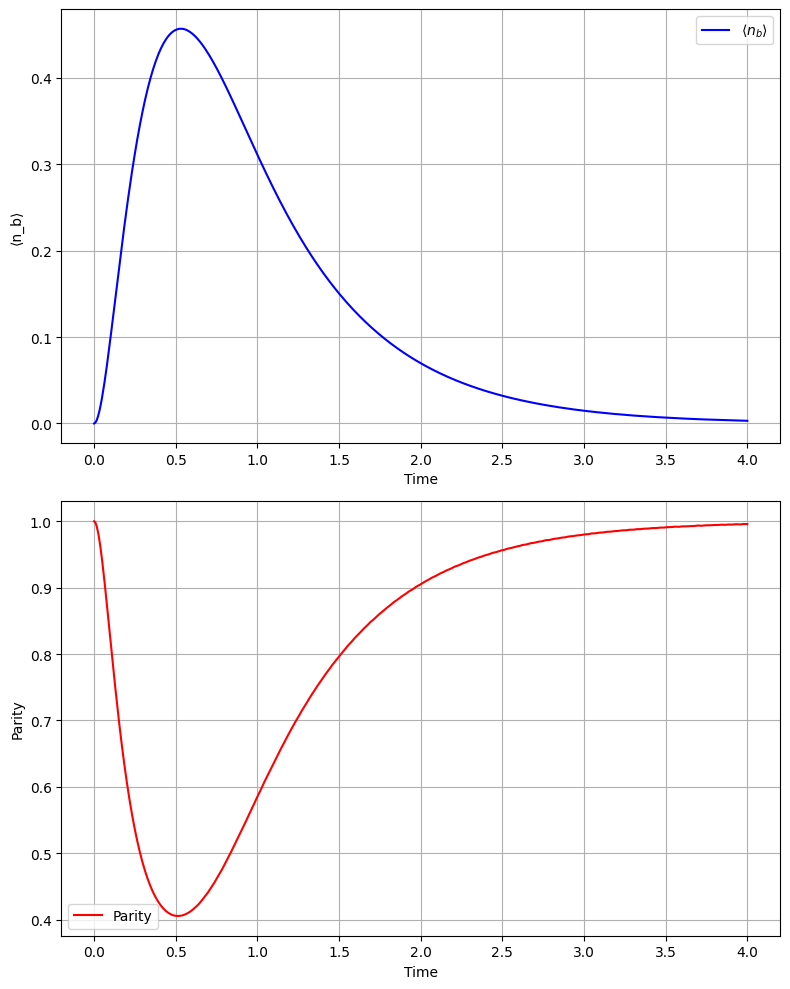

In [15]:
import dynamiqs as dq
import jax.numpy as jnp       
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from functools import reduce     # Import reduce to sum qarrays without starting with 0

# Hilbert-space truncations
na = 20   # Buffer mode a 
nb = 5    # Memory mode b

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Mode a annihilation operator
adag = a.dag()                                # Mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Mode b annihilation operator
bdag = b.dag()                                # Mode b creation operator

# Other parameters
g_2 = 1.0
eps_d = -4.0
kappa_b = 10

# Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag
H = H_2ph + H_d

# Initalizes both modees in the vacuum state
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# Creates time array
T = 4
t_save = jnp.linspace(0, T, 500) 

# Collapse operator on b
c_ops = [jnp.sqrt(kappa_b) * b]

# Solves the Linblad master equation
res = dq.mesolve(H, c_ops, psi0, t_save)

# Expectation value of n_b
n_b = bdag @ b

# Build the parity operator for mode b.
# Instead of using a diagonal function, sum over the Fock state projectors weighted by (-1)^n.
# It is assumed that dq.fock_dm(nb, n) creates the projector |n><n| for mode b.
terms = [ (-1)**n * dq.fock_dm(nb, n) for n in range(nb) ]
parity_b_local = reduce(lambda a, b: a + b, terms)
# Now, tensor with the identity for mode a.
parity_b = dq.tensor(dq.eye(na), parity_b_local)

# Compute expectation values for each time step.
n_b_expect = [dq.expect(n_b, state) for state in res.states]
parity_b_expect = [dq.expect(parity_b, state) for state in res.states]

# ---------------------------
# 6. Animate the Wigner function of mode a
# ---------------------------
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))

def update(frame):
    ax_w.cla()  # Clear the axis.
    # Obtain the reduced state of mode a by tracing out mode b.
    rho_a = dq.ptrace(res.states[frame], 0)
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Mode a Wigner Function\nTime = {t_save[frame]:.2f}")

ani = animation.FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_mode_a.gif'
ani.save(gif_filename, writer=PillowWriter(fps=25))
plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))

# ---------------------------
# 7. Plot the expectation value and parity for mode b
# ---------------------------
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the expectation value of the photon number in mode b.
ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_b⟩')
ax1.legend()
ax1.grid(True)

# Plot the photon number parity in mode b.
ax2.plot(t_save, parity_b_expect, label='Parity', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()